In [1]:
# !pip install graspologic
# !pip install POT

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
import os
import random
import pandas as pd
from scipy import ndimage
from skimage.util import img_as_ubyte
import time

from proglearn.sims.gaussian_sim import _generate_2d_rotation
from proglearn.forest import LifelongClassificationForest
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer
from proglearn.voters import TreeClassificationVoter

from skimage.transform import rotate
from multiprocessing import Pool
from functools import partial
import ot
from sklearn.neighbors import BallTree
import SimpleITK as sitk
from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes

In [2]:
# context = sns.plotting_context(context="poster", font_scale=1)
# sns.set_context(context)

In [2]:
def generate_posteriors(X, task_id, forest, transformers):
    vote_per_transformer_id = []
    for transformer_id in transformers:
        vote_per_bag_id = []
        for bag_id in range(
            len(forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id])
        ):
            transformer = forest.task_id_to_decider[task_id].transformer_id_to_transformers_[transformer_id][
                bag_id
            ]
            X_transformed = transformer.transform(X)
            voter = forest.task_id_to_decider[task_id].transformer_id_to_voters_[transformer_id][bag_id]
            vote = voter.predict_proba(X_transformed)
            vote_per_bag_id.append(vote)
        vote_per_transformer_id.append(np.mean(vote_per_bag_id, axis=0))

    return vote_per_transformer_id

### CIFAR

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()


In [4]:
# pickle_in = open("data.pickle", "rb")
# data = pickle.load(pickle_in)

In [4]:
# (X_train, y_train) = data[0]
# (X_test, y_test) = data[1]
data_x = np.concatenate([X_train, X_test])
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

In [5]:
def cross_val_data(data_x, data_y, total_cls=10):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]
    rand_class = list(range(total_cls))
    random.shuffle(rand_class)
    for i in rand_class:
        indx = idx[i]#np.roll(idx[i],(cv-1)*100)
        random.shuffle(indx)
        if i == rand_class[0]:
            train_x1 = x[indx[0:250],:]
            train_x2 = x[indx[250:500],:]
            train_y1 = y[indx[0:250]]
            train_y2 = y[indx[250:500]]

            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            train_x1 = np.concatenate((train_x1, x[indx[0:250],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x[indx[250:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:250]]), axis=0)
            train_y2 = np.concatenate((train_y2, y[indx[250:500]]), axis=0)

            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)
    return train_x1, train_y1, train_x2, train_y2, test_x, test_y

In [6]:
def image_aug(pic, angle, centroid_x=23, centroid_y=23, win=16, scale=1.45):
    im_sz = int(np.floor(pic.shape[0]*scale))
    pic_ = np.uint8(np.zeros((im_sz,im_sz,3),dtype=int))
    pic_[:,:,0] = ndimage.zoom(pic[:,:,0],scale)
    pic_[:,:,1] = ndimage.zoom(pic[:,:,1],scale)
    pic_[:,:,2] = ndimage.zoom(pic[:,:,2],scale)
    image_aug = rotate(pic_, angle, resize=False)
    image_aug_ = image_aug[centroid_x-win:centroid_x+win,centroid_y-win:centroid_y+win,:]
    return img_as_ubyte(image_aug_)

In [8]:
def reshape_images(X):
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))
    return X

In [94]:
def init_forest(max_depth):
    np.random.seed(1)
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}
    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}
    default_decider_class = SimpleArgmaxAverage
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                             default_transformer_kwargs = default_transformer_kwargs,
                             default_voter_class = default_voter_class,
                             default_voter_kwargs = default_voter_kwargs,
                             default_decider_class = default_decider_class)
    return progressive_learner

In [95]:
def experiment(angle, n_trees=10, max_depth=30, total_cls=10):
    # generate data
    train_x1, train_y1, train_x2, train_y2, test_x1, test_y1 =\
        cross_val_data(data_x, data_y, total_cls=total_cls)

    # rotate task2 data
    tmp_data = train_x2.copy()
    for i in range(len(tmp_data)):
        tmp_ = image_aug(tmp_data[i], angle)
        tmp_data[i] = tmp_
    # rotate test2 data
    tmp_data_test = test_x1.copy()
    for i in range(len(tmp_data_test)):
        tmp_ = image_aug(tmp_data_test[i], angle)
        tmp_data_test[i] = tmp_

    # permute data
    test_y2 = test_y1.copy()
    rand_idx = np.random.permutation(len(test_y2))
    tmp_data_test = tmp_data_test[rand_idx, :]
    test_y2 = test_y2[rand_idx]
        
    # reshape data
    train_x1 = reshape_images(train_x1)
    tmp_data = reshape_images(tmp_data)
    test_x1 = reshape_images(test_x1)
    tmp_data_test = reshape_images(tmp_data_test)
    
    l2f = init_forest(max_depth) 
    l2f.add_task(train_x1, train_y1, decider_kwargs = {"classes" : np.unique(train_y1)},
                num_transformers=n_trees)
    l2f.add_task(tmp_data, train_y2, decider_kwargs = {"classes" : np.unique(train_y2)},
                num_transformers=n_trees)
    l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(tmp_data_test, 1, l2f, [0,1])
    l2f_single_task1 = l2f.predict(test_x1, 0, [0])
    l2f_single_task2 = l2f.predict(tmp_data_test, 1, [1])

#     errors = np.zeros(2, dtype=float)
#     l2f = LifelongClassificationForest(
#             default_n_estimators=n_trees, default_max_depth=max_depth
#     )
#     l2f.add_task(X=train_x1, y=train_y1)
#     uf_task1 = l2f.predict(test_x1, task_id=0)
#     l2f.add_transformer(X=tmp_data, y=train_y2)
#     l2f_task1 = l2f.predict(test_x1, task_id=0)
#     errors[1] = (1 - np.mean(l2f_task1 == test_y1))
#     errors[0] = (1 - np.mean(uf_task1 == test_y1))
    
    alg = run_OT(l2f_task1[0], l2f_task2[1], test_y1, test_y2)
    errors = np.zeros(len(alg)*2+4,dtype=float)
    
    # L2F
    l2f_pred_task1 = np.mean([l2f_task1[0], l2f_task1[1]], axis=0)
    errors[2] = (1 - np.mean(np.argmax(l2f_pred_task1, axis=1) == test_y1))
    l2f_pred_task2 = np.mean([l2f_task2[0], l2f_task2[1]], axis=0)
    errors[3] = (1 - np.mean(np.argmax(l2f_pred_task2, axis=1) == test_y2))
    # UF
    errors[0] = 1 - np.mean(l2f_single_task1 == test_y1)
    errors[1] = 1 - np.mean(l2f_single_task2 == test_y2)

    for i in range(len(alg)):
        deformed_task1 = alg[i][0]
        deformed_task2 = alg[i][1]
        l2f_pred_task1_proc = np.mean([l2f_task1[0], deformed_task1], axis=0)
        errors[i*2+4] = (1 - np.mean(np.argmax(l2f_pred_task1_proc, axis=1) == test_y1))
        l2f_pred_task2_proc = np.mean([l2f_task2[1], deformed_task2], axis=0)
        errors[i*2+5] = (1 - np.mean(np.argmax(l2f_pred_task2_proc, axis=1) == test_y2))
    
    return errors

In [96]:
def run(cls):
#     angles = [0,30,60,90,120,150,180]
    angles = [90]
    errors = np.empty((len(angles), 8))
    for i,angle in enumerate(angles):
        errors[i,:] = experiment(angle, total_cls=cls)
        
    return errors

In [58]:
# start_time = time.time()
# print(experiment(90))
# print("--- %s seconds ---" % (time.time() - start_time))

In [3]:
# errors_all_avg = np.mean(errors_all, axis=0)
# errors_all_avg

In [112]:
# pickle_in = open("store/errors_TE-cifar-OT-reg-pos-asPt-10cls.pickle", "rb")
# e10 = pickle.load(pickle_in)
# e10_avg = np.mean(e10, axis=0)
# pickle_in = open("store/errors_TE-cifar-OT-reg-pos-asPt-5cls.pickle", "rb")
# e5 = pickle.load(pickle_in)
# e5_avg = np.mean(e5, axis=0)
pickle_in = open("store/errors_TE-cifar-OT-reg-pos-asPt-2cls.pickle", "rb")
e2 = pickle.load(pickle_in)
# e2_avg = np.mean(e2, axis=0)
pickle_in = open("store/errors_TE-cifar-OT-reg-pos-asPt-2cls_1.pickle", "rb")
e2_1 = pickle.load(pickle_in)
e2.extend(e2_1)
e2_avg = np.mean(e2, axis=0)

In [113]:
# angles = [0,30,60,90,120,150,180]
mean_te2 = np.zeros((2, 3, len(angles)))
for i in range(2):
    for j in range(3):
        for k in range(len(angles)):
            mean_te2[i,j,k] =\
            e2_avg[k,i] / e2_avg[k,j*2+2+i]
mean_te2

array([[[0.98952176, 0.99073829, 0.97692711, 0.96951692, 0.99045281,
         0.98965243, 0.99285125],
        [1.00793651, 1.00510067, 0.99785753, 1.        , 1.00248482,
         0.99679316, 1.00389213],
        [1.00876472, 1.00645161, 1.00350121, 0.99866951, 0.99835029,
         0.99679316, 1.00781468]],

       [[1.04041298, 1.0551986 , 1.05196629, 1.0384184 , 1.05069671,
         1.06453472, 1.04794318],
        [0.9968909 , 0.99944675, 1.00187266, 1.00761905, 1.00624645,
         1.00516866, 0.99887165],
        [1.00056738, 1.00472747, 1.00187266, 1.00926683, 1.00911162,
         1.00626362, 1.00539466]]])

In [3]:
context = sns.plotting_context(context="poster", font_scale=1.4)
sns.set_context(context)

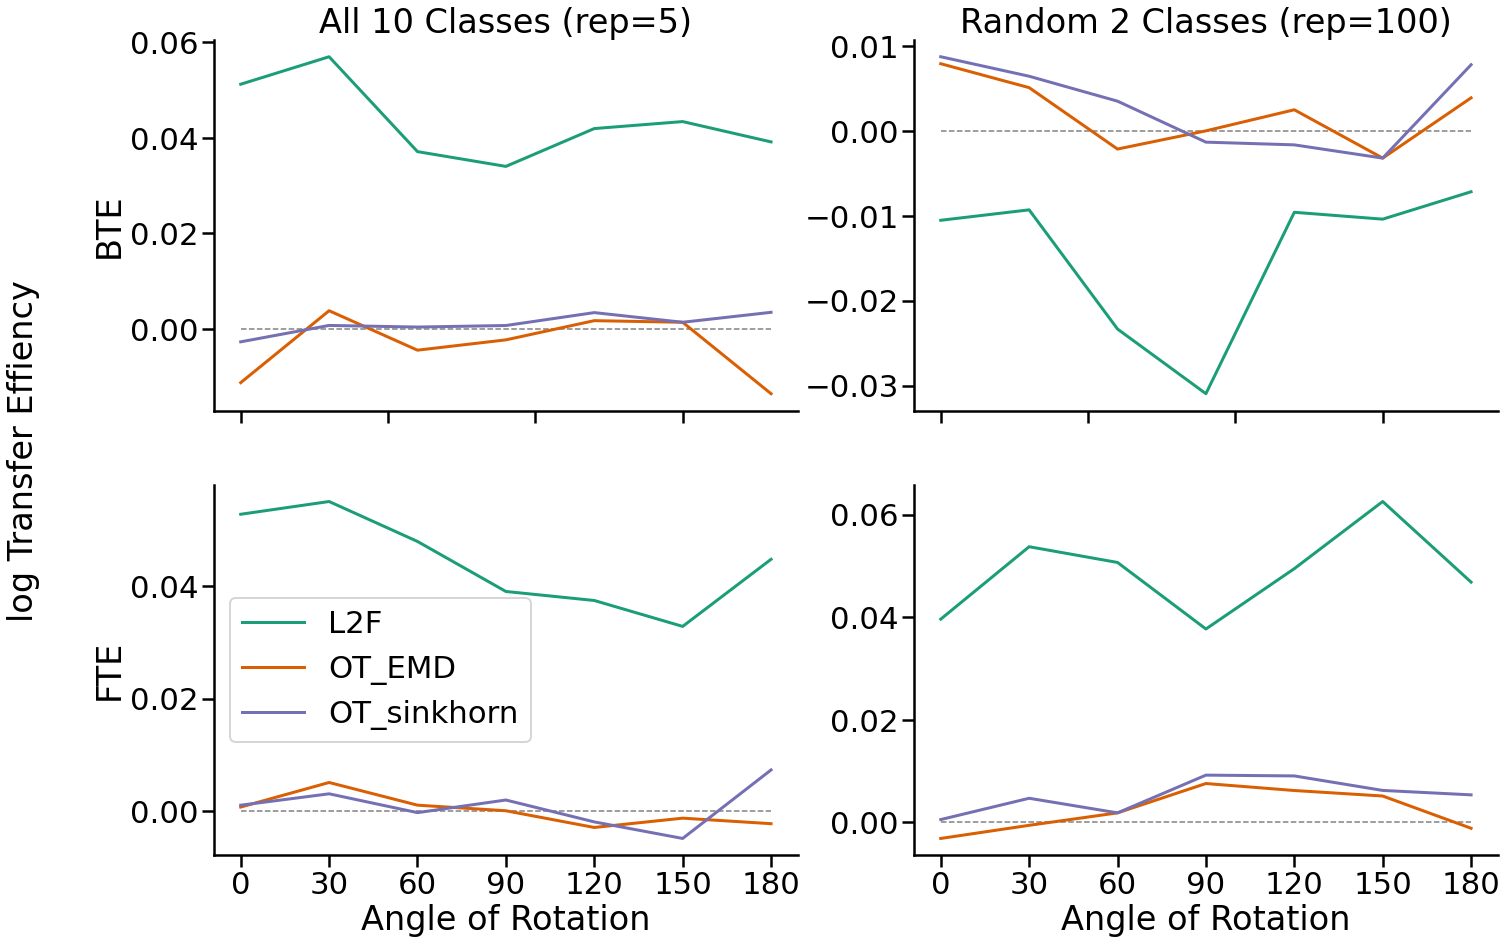

In [126]:
colors = sns.color_palette('Dark2', n_colors=e2_avg.shape[1])
angles = [0,30,60,90,120,150,180]
alg_names = ['L2F','OT_EMD','OT_sinkhorn']
fig,axs = plt.subplots(2,2,figsize=(23,15))
mean_tes = [mean_te10, mean_te2]
titles = ['All 10 Classes', 'Random 2 Classes']
reps = [5,100]
for cls in range(2):
    mean_te = mean_tes[cls].copy()
    ax = axs[0,cls]
    for i in range(3):
        ax.plot(angles, np.log(mean_te[0,i,:]),
                linewidth = 3, label=alg_names[i], color=colors[i])
    ax.set_xticklabels("")
    ax.hlines(0, 0,180, colors='gray', linestyles='dashed',linewidth=1.5)
    if cls == 0:
        ax.set_ylabel("BTE")
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    ax.set_title(titles[cls]+' (rep=%i)'% reps[cls])

    ax = axs[1,cls]
    for i in range(3):
        ax.plot(angles, np.log(mean_te[1,i,:]),
                linewidth = 3, label=alg_names[i], color=colors[i])
    ax.set_xticks(angles)
    ax.set_xticklabels(angles)
    if cls == 0:
        ax.set_ylabel('FTE')
        ax.legend()
    ax.set_xlabel('Angle of Rotation')
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    ax.hlines(0, 0,180, colors='gray', linestyles='dashed',linewidth=1.5)
fig.text(0,0.5,'log Transfer Effiency', va='center', rotation='vertical')
plt.savefig('cifar_OT')

In [5]:
# array_ = np.vstack((errors_all_avg[:,:2], errors_all_avg[:,2:4]))
# df = pd.DataFrame(array_)
# df['alg'] = ""
# df['alg'].iloc[[0,1,2,3,4,5,6]] = 'L2F o ortho procrustes'
# df['alg'].iloc[[7,8,9,10,11,12,13]] = 'L2F'
# df.columns = ['error on task1', 'error on task2', 'alg']
# angles = np.append(np.linspace(0,180,num=7), np.linspace(0,180,num=7))
# df['Angle of Rotation'] = angles.astype(int)
# df = pd.melt(df, id_vars=['alg', 'Angle of Rotation'],\
#              var_name='type', value_name='Generalization Error')

In [6]:
# fig,ax = plt.subplots(1, figsize=(20,10))
# sns.lineplot(data=df, x=df['Angle of Rotation'], y=df['Generalization Error'], hue='alg', style='type', ax=ax)
# ax.set_xticks(np.linspace(0,180,num=7))


### optimal transport

#### OT point cloud

In [3]:
def OT_reg_pos_asPt(Xs, Xt):
    # EMD Transport
    ot_emd = ot.da.EMDTransport()
    ot_emd.fit(Xs=Xs, Xt=Xt)
    transp_Xs_emd = ot_emd.transform(Xs=Xs)
    ot_emd = ot.da.EMDTransport()
    ot_emd.fit(Xs=Xt, Xt=Xs)
    transp_Xt_emd = ot_emd.transform(Xs=Xt)

    # Sinkhorn Transport
    ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
    ot_sinkhorn.fit(Xs=Xs, Xt=Xt)
    transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
    ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
    ot_sinkhorn.fit(Xs=Xt, Xt=Xs)
    transp_Xt_sinkhorn = ot_sinkhorn.transform(Xs=Xt)
    
    alg = [[transp_Xs_emd, transp_Xt_emd], [transp_Xs_sinkhorn, transp_Xt_sinkhorn]]
    return alg

In [16]:
# def run_OT(Xs, Xt, ys, yt):
#     # EMD Transport
#     ot_emd = ot.da.EMDTransport()
#     ot_emd.fit(Xs=Xs, Xt=Xt)

#     # Sinkhorn Transport
#     ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
#     ot_sinkhorn.fit(Xs=Xs, Xt=Xt)

# #     # Sinkhorn Transport with Group lasso regularization
# #     ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
# #     ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)

# #     # Sinkhorn Transport with Group lasso regularization l1l2
# #     ot_l1l2 = ot.da.SinkhornL1l2Transport(reg_e=1e-1, reg_cl=2e0, max_iter=20,
# #                                           verbose=True)
# #     ot_l1l2.fit(Xs=Xs, ys=ys, Xt=Xt)

#     # transport source samples onto target samples
#     transp_Xs_emd = ot_emd.transform(Xs=Xs)
#     transp_Xt_emd = ot_emd.inverse_transform(Xt=Xt)
#     transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
#     transp_Xt_sinkhorn = ot_sinkhorn.inverse_transform(Xt=Xt)
# #     transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)
# #     transp_Xt_lpl1 = ot_lpl1.inverse_transform(Xt=Xt)
# #     transp_Xs_l1l2 = ot_l1l2.transform(Xs=Xs)
# #     transp_Xt_l1l2 = ot_l1l2.inverse_transform(Xt=Xt)
    
# #     alg = [[transp_Xs_emd, transp_Xt_emd], [transp_Xs_sinkhorn, transp_Xt_sinkhorn],
# #       [transp_Xs_lpl1, transp_Xt_lpl1], [transp_Xs_l1l2, transp_Xt_l1l2]]

#     alg = [[transp_Xs_emd, transp_Xt_emd], [transp_Xs_sinkhorn, transp_Xt_sinkhorn]]
#     return alg

In [4]:
def vote_to_pred(vote, test_task, test_grid):
    tree = BallTree(test_grid)
    pred = np.zeros(test_task.shape)
    ind = tree.query(test_task.reshape(-1,2), k=1, return_distance=False)
    for i in range(len(test_task)):
        pred[i,0] = vote[ind[i]]
        pred[i,1] = 1 - pred[i,0]
        
    return pred

In [5]:
def reshape_posteriors(inside, task):
    inside_ravel = inside.ravel()
    preds = np.zeros(inside_ravel.shape)
    j = 0
    for i in range(len(inside_ravel)):
        if inside_ravel[i]:
            preds[i] = task[j]
            j += 1
    preds = preds.reshape(inside.shape)
    
    return preds

In [6]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [7]:
def rotate_data(X, theta):
    R = np.array([[np.cos(theta), np.sin(theta)],
                  [-np.sin(theta), np.cos(theta)]])
    X = X @ R
    return X

In [8]:
def init_forest(max_depth, n_cls):
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(n_cls)}
    l2f = ProgressiveLearner(default_transformer_class = default_transformer_class,
            default_transformer_kwargs = default_transformer_kwargs,
            default_voter_class = default_voter_class,
            default_voter_kwargs = default_voter_kwargs,
            default_decider_class = default_decider_class,
            default_decider_kwargs = default_decider_kwargs)
    return l2f

In [9]:
def get_random_pt(xlim_, ylim_):
    x = random.uniform(xlim_[0], xlim_[1])
    y = random.uniform(ylim_[0], ylim_[1])
    return x,y

def generate_rand_ellipse(n_sample):
    data = []
    label = []
    max_ite = 1000
    xlim_ = [-6,6]
    ylim_ = [-3,3]
    ite = 0
    while len(data) < n_sample:
        if ite < max_ite:
            x,y = get_random_pt(xlim_, ylim_)
            if (x**2 / 6**2 + y**2 / 3**2 < 1) & (x**2 / 4**2 + y**2 / 2**2 > 1):
                data.append([x,y])
                label.append(0)
            if (x**2 / 2**2 + y**2 / 1**2 > 1) & (x**2 / 4**2 + y**2 / 2**2 < 1):
                data.append([x,y])
                label.append(1)
            ite += 1
    return np.array(data), np.array(label)

In [19]:
# def OT_reg_data(Xs, Xt, ys):
#     # EMD Transport
#     ot_emd = ot.da.EMDTransport()
#     ot_emd.fit(Xs=Xs, Xt=Xt)

#     # Sinkhorn Transport
#     ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
#     ot_sinkhorn.fit(Xs=Xs, Xt=Xt)

#     # Sinkhorn Transport with Group lasso regularization
#     ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
#     ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)

#     # transport source samples onto target samples
#     transp_Xs_emd = ot_emd.transform(Xs=Xs)
#     transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
#     transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)
    
#     return [transp_Xs_emd, transp_Xs_sinkhorn, transp_Xs_lpl1]

In [160]:
# def exp_reg_data(angle, max_depth=30, n_trees=10, n_samples_source=200):
#     angle = np.pi*angle/180
#     reg_idx = [0,1,2]
#     train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
#     train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
#     train_x2_rot = rotate_data(train_x2, angle)
#     train_x2_reg = [OT_reg_data(train_x2_rot, train_x2, train_y2)[i]
#                     for i in reg_idx]
#     test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
#     test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
#     test_x2_rot = rotate_data(test_x2, angle)
#     test_x2_reg = [OT_reg_data(test_x2_rot, test_x2, test_y2)[i]
#                    for i in reg_idx]
    
#     errors = np.zeros(4*(len(reg_idx)+1), dtype=float)
#     for train_time in range(len(reg_idx)+1):
#         if train_time == 0:
#             train_x2_data = train_x2_rot.copy()
#             test_x2_data = test_x2_rot.copy()
#         else:
#             train_x2_data = train_x2_reg[train_time-1].copy()
#             test_x2_data = test_x2_reg[train_time-1].copy()
#         l2f = init_forest(max_depth, 2) 
#         uf = init_forest(max_depth, 2)
#         l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
#         l2f.add_task(train_x2_data, train_y2, num_transformers=n_trees)
#         uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
#         uf.add_task(train_x2_data, train_y2, num_transformers=2*n_trees)
#         uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
#         l2f_task1 = l2f.predict(test_x1, task_id=0)
#         uf_task2 = uf.predict(test_x2_data, transformer_ids=[1], task_id=1)
#         l2f_task2 = l2f.predict(test_x2_data, task_id=1)

#         # UF
#         errors[0+train_time*4] = 1 - np.mean(uf_task1 == test_y1)
#         errors[1+train_time*4] = 1 - np.mean(uf_task2 == test_y2)
#         # L2F
#         errors[2+train_time*4] = 1 - np.mean(l2f_task1 == test_y1)
#         errors[3+train_time*4] = 1 - np.mean(l2f_task2 == test_y2)

#     return errors


In [10]:
def exp_reg_pos_asPt(angle, n_trees=10, n_samples_source=200):
#     angle=0; n_trees=10; n_samples_source=200
    angle = np.pi*angle/180
    train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
    train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
    train_x2_rot = rotate_data(train_x2, angle)

    test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
    test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
    test_x2_rot = rotate_data(test_x2, angle)

    max_depth = ceil(log2(n_samples_source))
    l2f = init_forest(max_depth, 2) 
    uf = init_forest(max_depth, 2)
    l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
    l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
    uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
    uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)

    # L2F
    l2f_task1 = generate_posteriors(test_x1, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_x2_rot, 1, l2f, [0,1])

    errors = np.zeros(6,dtype=float)
    l2f_pred_task1 = np.mean([l2f_task1[0], l2f_task1[1]], axis=0)
    errors[2] = 1 -\
        np.mean(np.argmax(l2f_pred_task1, axis=1) == test_y1)
    l2f_pred_task2 = np.mean([l2f_task2[0], l2f_task2[1]], axis=0)
    errors[3] = 1 -\
        np.mean(np.argmax(l2f_pred_task2, axis=1) == test_y2)

    # UF
    uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
    uf_task2 = uf.predict(test_x2_rot, transformer_ids=[1], task_id=1)
    errors[0] = 1 - np.mean(uf_task1 == test_y1)
    errors[1] = 1 - np.mean(uf_task2 == test_y2)

    # procrustes
    aligner = SeedlessProcrustes(iterative_num_reps=500)
    aligner.fit(l2f_task1[0], l2f_task2[1])
    Q_ = aligner.initial_Q
    aligner = SeedlessProcrustes(iterative_num_reps=500, init='custom', initial_Q=Q_)
    deformed_task1 = aligner.fit_transform(l2f_task1[0], l2f_task2[1])
    
    aligner = SeedlessProcrustes(iterative_num_reps=500)
    aligner.fit(l2f_task2[1], l2f_task1[0])
    Q_ = aligner.initial_Q
    aligner = SeedlessProcrustes(iterative_num_reps=500, init='custom', initial_Q=Q_)
    deformed_task2 = aligner.fit_transform(l2f_task2[1], l2f_task1[0])
    
    l2f_pred_task1_proc = np.mean([l2f_task1[0], deformed_task1], axis=0)
    errors[4] = 1 - np.mean(np.argmax(l2f_pred_task1_proc, axis=1) == test_y1)
    l2f_pred_task2_proc = np.mean([l2f_task2[1], deformed_task2], axis=0)
    errors[5] = 1 - np.mean(np.argmax(l2f_pred_task2_proc, axis=1) == test_y2)
    return errors

In [41]:
rep = 100
errors = Parallel(n_jobs=10, verbose=1)(delayed(exp_reg_pos_asPt)(45) for _ in range(rep))
np.mean(errors, axis=0)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.2min finished


array([0.0781 , 0.10735, 0.08155, 0.1194 , 0.0788 , 0.1106 ])

In [20]:
def exp(angle, max_depth=30, n_trees=10, n_samples_source=200):
    angle = np.pi*angle/180
    train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
    train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
    train_x2_rot = rotate_data(train_x2, angle)

    test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
    test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
    test_x2_rot = rotate_data(test_x2, angle)
    
    errors = np.zeros(4, dtype=float)
    l2f = init_forest(max_depth, 2) 
    uf = init_forest(max_depth, 2)
    l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
    l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
    uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
    uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)
    uf_task1 = uf.predict(test_x1, transformer_ids=[0], task_id=0)
    l2f_task1 = l2f.predict(test_x1, task_id=0)
    uf_task2 = uf.predict(test_x2_rot, transformer_ids=[1], task_id=1)
    l2f_task2 = l2f.predict(test_x2_rot, task_id=1)

    # UF
    errors[0] = 1 - np.mean(uf_task1 == test_y1)
    errors[1] = 1 - np.mean(uf_task2 == test_y2)
    # L2F
    errors[2] = 1 - np.mean(l2f_task1 == test_y1)
    errors[3] = 1 - np.mean(l2f_task2 == test_y2)

    return errors


In [197]:
def run():
    angles = [0,15,30,45,60,75,90, 105,120,135,150,165,180]
    errors = np.empty((len(angles), 4))
    for i,angle in enumerate(angles):
        errors[i,:] = exp(angle)
        
    return errors

In [199]:
rep = 100
errors = Parallel(n_jobs=1, verbose=1)(delayed(run)() for _ in range(rep))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 21.1min finished


In [118]:
# pickle_in = open("store/errors_TE-ellipse-OT-reg-data.pickle", "rb")
# errors_reg_data = pickle.load(pickle_in)

In [142]:
pickle_in = open("store/errors_TE-ellipse-OT-reg-pos-asPt.pickle", "rb")
errors_reg_pos = pickle.load(pickle_in)

In [143]:
pickle_in = open("store/errors_TE-ellipse-OT-reg-pos-asImg.pickle", "rb")
errors_reg_Img_OT = pickle.load(pickle_in)

In [144]:
pickle_in = open("store/errors_TE-ellipse-sitk-reg-pos-asImg.pickle", "rb")
errors_reg_Img_sitk = pickle.load(pickle_in)

In [139]:
pickle_in = open("store/errors_TE-ellipse-sitk-reg-pos-asImg-105_120.pickle", "rb")
errors_reg_Img_sitk_105120 = pickle.load(pickle_in)

In [140]:
e_avg = np.mean(errors_reg_Img_sitk_105120, axis=0)
mean_te_all_reg_Img_sitk_105120 = []
for n_alg in range(2):
    e_single = np.hstack((e_avg[:,:2], e_avg[:,n_alg*2+2:n_alg*2+4]))
    mean_te = np.zeros((2,2))
    for i in range(mean_te.shape[0]):
        for j in range(mean_te.shape[1]):
            mean_te[i,j] = e_single[j,i] / e_single[j,i+2]
    mean_te_all_reg_Img_sitk_105120.append(mean_te)
mean_te_all_reg_Img_sitk_105120

[array([[1.00413723, 0.97999254],
        [0.93517366, 0.88770332]]),
 array([[1.02275527, 1.0860763 ],
        [0.86654786, 1.01800087]])]

In [145]:
e_avg = np.mean(errors_reg_Img_sitk, axis=0)
mean_te_all_reg_Img_sitk = []
for n_alg in range(2):
    e_single = np.hstack((e_avg[:,:2], e_avg[:,n_alg*2+2:n_alg*2+4]))
    mean_te = np.zeros((2,13))
    for i in range(mean_te.shape[0]):
        for j in range(mean_te.shape[1]):
            mean_te[i,j] = e_single[j,i] / e_single[j,i+2]
    mean_te_all_reg_Img_sitk.append(mean_te)

e_avg = np.mean(errors_reg_Img_OT, axis=0)
mean_te_all_reg_Img_OT = []
for n_alg in range(2):
    e_single = np.hstack((e_avg[:,:2], e_avg[:,n_alg*2+2:n_alg*2+4]))
    mean_te = np.zeros((2,13))
    for i in range(mean_te.shape[0]):
        for j in range(mean_te.shape[1]):
            mean_te[i,j] = e_single[j,i] / e_single[j,i+2]
    mean_te_all_reg_Img_OT.append(mean_te)
    
e_avg = np.mean(errors_reg_pos, axis=0)
mean_te_all_reg_pos = []
for n_alg in range(2):
    e_single = np.hstack((e_avg[:,:2], e_avg[:,n_alg*2+2:n_alg*2+4]))
    mean_te = np.zeros((2,13))
    for i in range(mean_te.shape[0]):
        for j in range(mean_te.shape[1]):
            mean_te[i,j] = e_single[j,i] / e_single[j,i+2]
    mean_te_all_reg_pos.append(mean_te)

In [154]:
mean_te_all_reg_Img_sitk[1][:,7:9] = mean_te_all_reg_Img_sitk_105120[1]

In [121]:
# e_avg = np.mean(errors_reg_data, axis=0)
# mean_te_all_reg_data = []
# for n_alg in range(4):
#     e_single = e_avg[:,4*n_alg:4*(n_alg+1)]
#     mean_te = np.zeros((2,13))
#     for i in range(mean_te.shape[0]):
#         for j in range(mean_te.shape[1]):
#             mean_te[i,j] = e_single[j,i] / e_single[j,i+2]
#     mean_te_all_reg_data.append(mean_te)

In [9]:
angle = np.pi*45/180
train_x1, train_y1 = generate_rand_ellipse(200)
train_x2, train_y2 = generate_rand_ellipse(200)
train_x2_rot = rotate_data(train_x2, angle)

NameError: name 'generate_rand_ellipse' is not defined

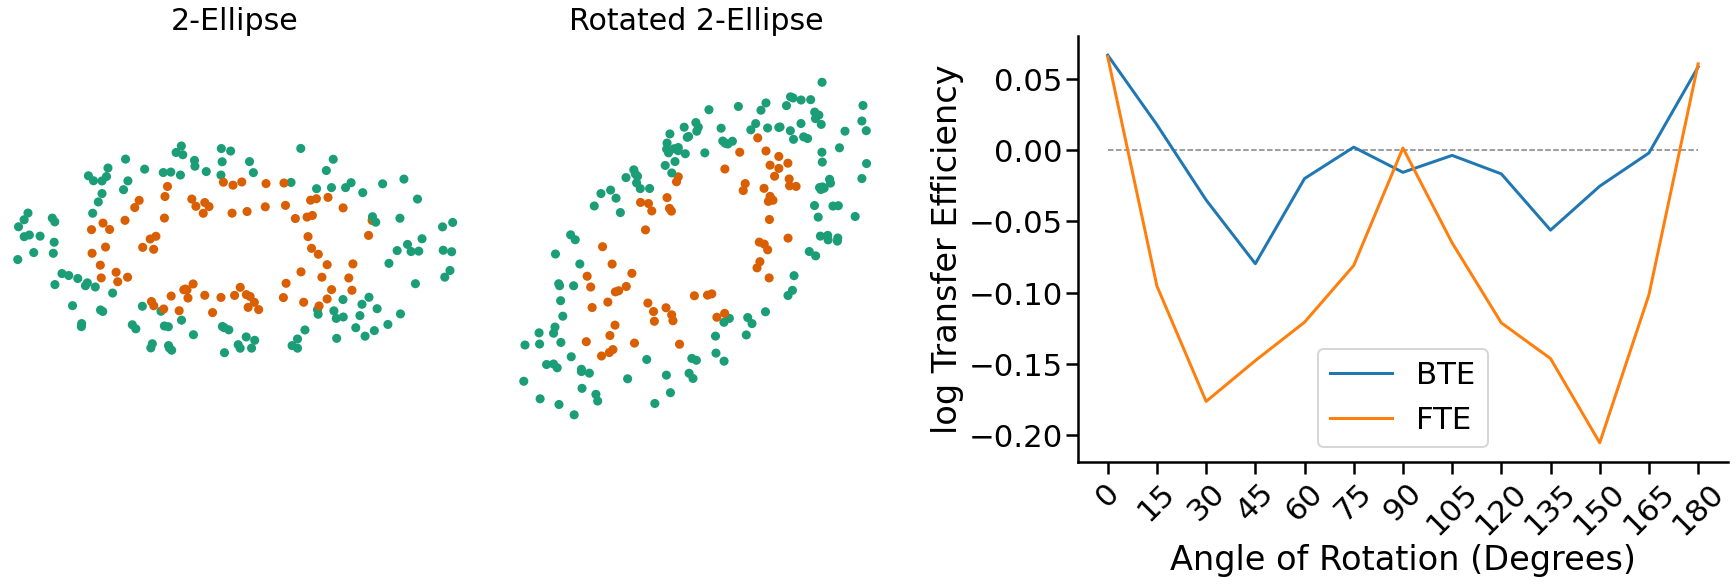

In [128]:
colors = sns.color_palette('Dark2', n_colors=5)
# fig, axs = plt.subplots(1,3, figsize=(24,8))
fig = plt.figure(constrained_layout=True, figsize=(24,8))
gs = fig.add_gridspec(8, 24)
data = [train_x1, train_x2_rot]
label = [train_y1, train_y2]
titles = ['2-Ellipse', 'Rotated 2-Ellipse']
for i in range(len(data)):
    ax = fig.add_subplot(gs[:,:7]) if i == 0 else fig.add_subplot(gs[:,7:14])
    clr = [colors[i] for i in label[i]]
    ax.scatter(data[i][:, 0], data[i][:, 1], c=clr, s=50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=30)
    ax.axis('off')
    ax.set_xlim([-6,6]); ax.set_ylim([-6,6])
ax = fig.add_subplot(gs[:,14:])
labels = ['BTE', 'FTE']
for i in range(2):
    ax.plot(range(0,195,15), np.log(mean_te_all_reg_pos[0][i]), linewidth=3, label=labels[i])
ax.set_xticks(range(0,195,15))
ax.set_xticklabels(range(0,195,15), rotation=45)
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('log Transfer Efficiency')
ax.hlines(0, 0, 180, colors='gray', linestyles='dashed',linewidth=1.5)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.legend()
plt.savefig('ellipse-sample')

In [169]:
context = sns.plotting_context(context="poster", font_scale=1)
sns.set_context(context)

Text(0.55, 0.9, 'Register Posteriors (on grid) as Image')

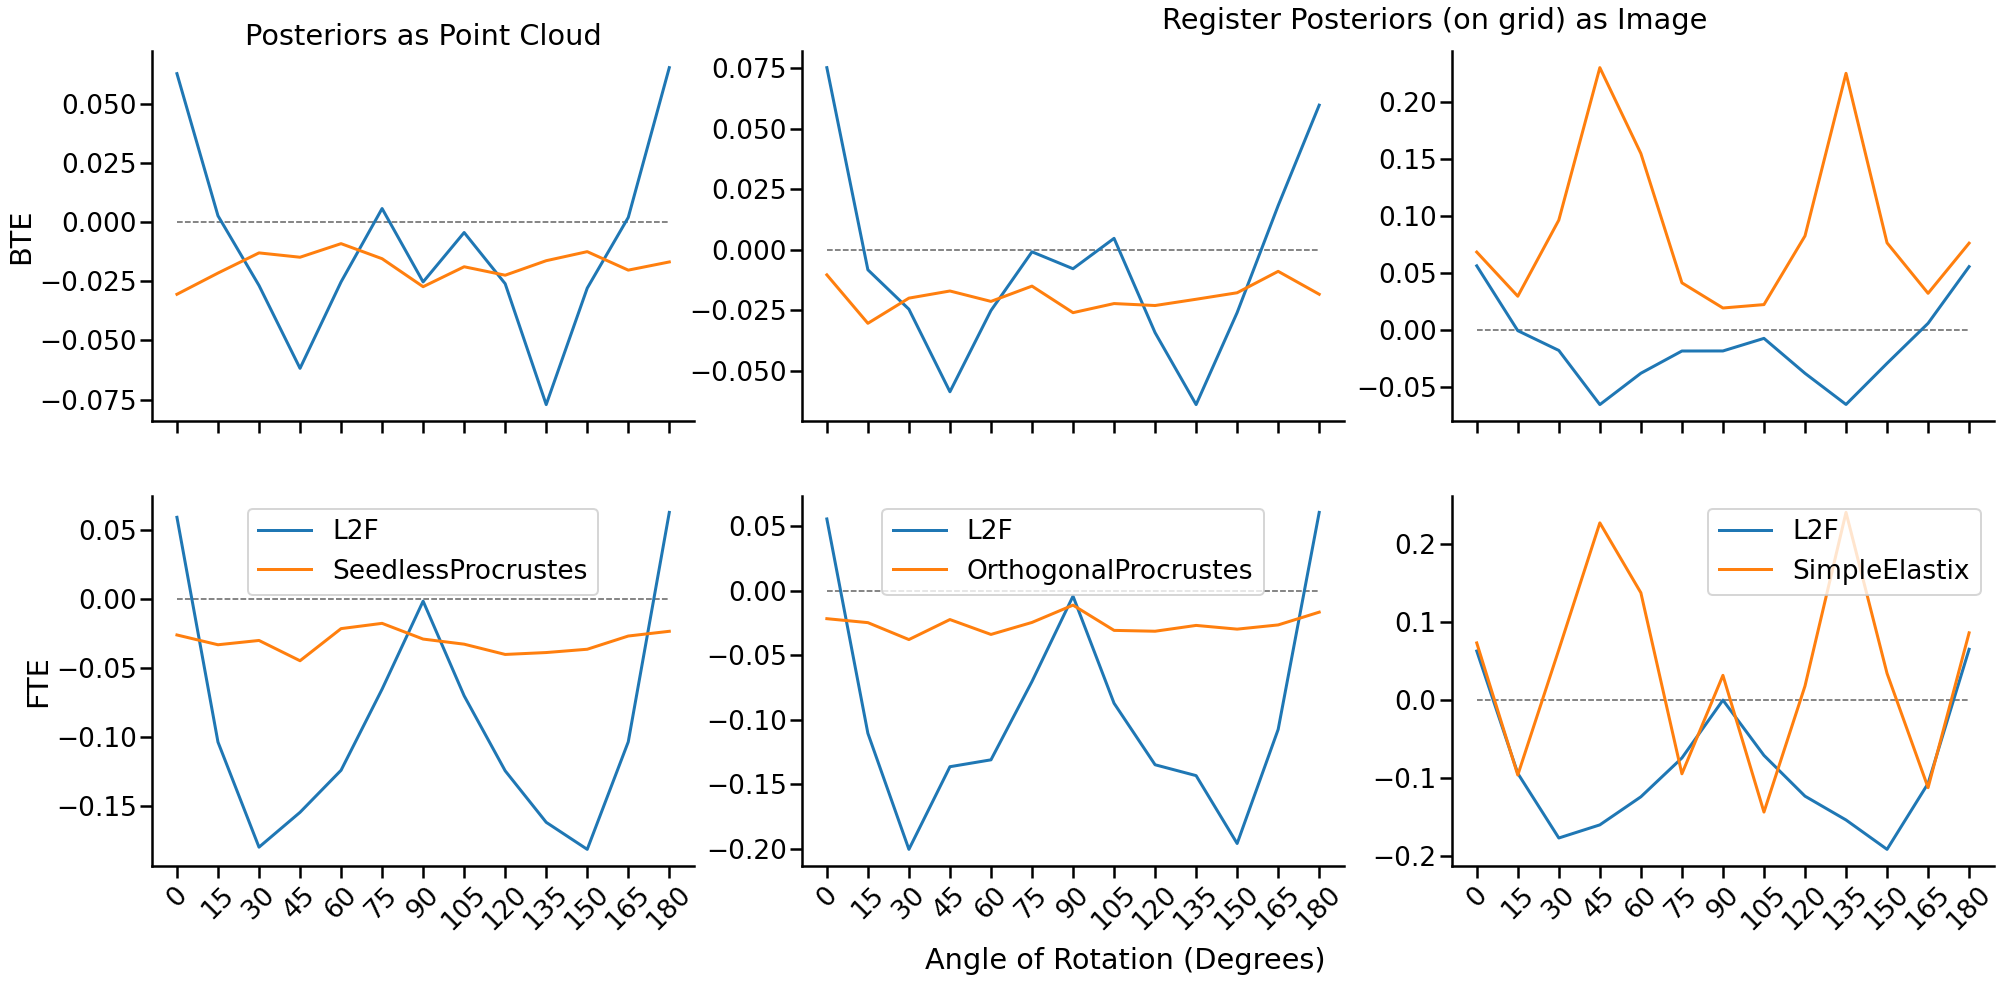

In [162]:
colors = sns.color_palette('Dark2', n_colors=5)
fig, axs = plt.subplots(2,3, figsize=(33,15))
data = [mean_te_all_reg_pos, mean_te_all_reg_Img_OT, mean_te_all_reg_Img_sitk]
ylabels = ['BTE','FTE']
titles = ['Posteriors as Point Cloud']
labels = [['L2F', 'SeedlessProcrustes'],['L2F', 'OrthogonalProcrustes'], ['L2F', 'SimpleElastix']] 
for data_idx in range(len(data)):
    for j in range(2):
        ax = axs[j,data_idx]
        for k in range(len(data[data_idx])):
            ax.plot(
                range(0,195,15), np.log(data[data_idx][k][j]), linewidth=3, label=labels[data_idx][k]
            )
            ax.set_xticks(range(0,195,15))
            ax.set_xticklabels(range(0,195,15), rotation=45)
            if data_idx == 0:
                ax.set_ylabel(ylabels[j])
            ax.hlines(0, 0, 180, colors='gray', linestyles='dashed',linewidth=1.5)
            right_side = ax.spines["right"]
            right_side.set_visible(False)
            top_side = ax.spines["top"]
            top_side.set_visible(False)
        if j == 0:
            if data_idx == 0:
                ax.set_title(titles[data_idx])
            ax.set_xticklabels("")
        else:
            ax.legend()

fig.text(0.45,0.03,'Angle of Rotation (Degrees)')
fig.text(0.55,0.9,'Register Posteriors (on grid) as Image')
# plt.savefig('ellipse-TEs-Img')

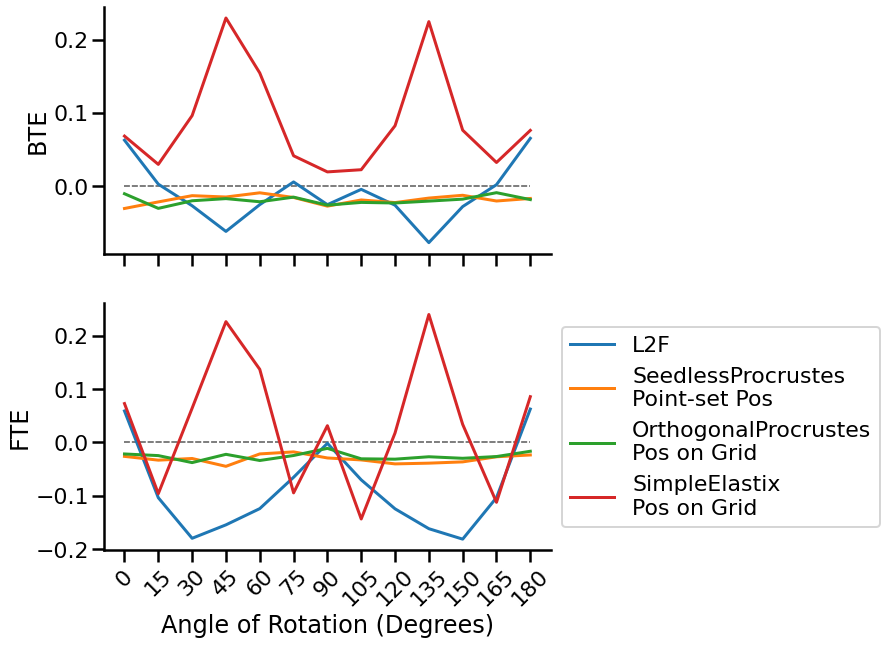

In [170]:
colors = sns.color_palette('Dark2', n_colors=5)
fig, axs = plt.subplots(2,1, figsize=(8,10))
data = [mean_te_all_reg_pos[0], mean_te_all_reg_pos[1],
        mean_te_all_reg_Img_OT[1], mean_te_all_reg_Img_sitk[1]]
ylabels = ['BTE','FTE']
titles = ['Posteriors as Point Cloud']
labels = ['L2F', 'SeedlessProcrustes\nPosteriors as Point Cloud',
          'OrthogonalProcrustes\nPosteriors on Grid','SimpleElastix\nPosteriors on Grid']
line_styles = ['--','']
for j in range(2):
    ax = axs[j]
    for data_idx in range(len(data)):
        ax.plot(
            range(0,195,15), np.log(data[data_idx][j]), linewidth=3, label=labels[data_idx]
        )
        ax.set_xticks(range(0,195,15))
        ax.set_xticklabels(range(0,195,15), rotation=45)
        ax.set_ylabel(ylabels[j])
        ax.hlines(0, 0, 180, colors='gray', linestyles='dashed',linewidth=1.5)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top_side = ax.spines["top"]
        top_side.set_visible(False)
        if j == 0:
            ax.set_xticklabels("")
        else:
            ax.set_xlabel('Angle of Rotation (Degrees)')
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('ellipse-TEs-Img')

In [164]:
for i in range(4):
    e_single = e_avg[4*i:4*(i+1)]
    print(e_single[0]/e_single[2], e_single[1]/e_single[3])

0.9740500463392031 0.8575750523621138
1.0661638669866293 1.0693069306930687
1.0437834224598923 1.0763308402991636
1.0188863562357533 1.0928375343149492


In [165]:
def run():
#     angles = [0,15,30,45,60,75,90]
    angles = [0,15,30,45,60,75,90, 105,120,135,150,165,180]
    errors = np.empty((len(angles), 16))
    for i,angle in enumerate(angles):
        errors[i,:] = exp(angle)
        
    return errors

In [167]:
rep = 10
errors_all = Parallel(n_jobs=10, verbose=1)(delayed(run)() for _ in range(rep))



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  2.1min remaining:  8.4min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  2.7min finished


In [17]:
# errors_all_avg = np.mean(errors_all, axis=0)
# errors_all_avg

In [121]:
mean_te = np.zeros((2,13))
for i in range(mean_te.shape[0]):
    for j in range(mean_te.shape[1]):
        mean_te[i,j] = errors_all_avg[j,i] / errors_all_avg[j,i+2]
mean_te

array([[1.06097024, 1.00864749, 0.9727253 , 0.94669079, 0.96364482,
        1.        , 0.99761774, 0.99592045, 0.96748575, 0.94340314,
        0.97735132, 1.01000583, 1.06703641],
       [1.06116187, 0.90136449, 0.82495144, 0.84815194, 0.87138256,
        0.92658601, 1.00729268, 0.92378058, 0.88147946, 0.84805947,
        0.82137522, 0.90218737, 1.07586254]])

#### OT reg images

In [10]:
# r = np.random.RandomState(42)
# def im2mat(img):
#     """Converts and image to matrix (one pixel per line)"""
# #     return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
#     return img.reshape((img.shape[0] * img.shape[1], 1))

# def mat2im(X, shape):
#     """Converts back a matrix to an image"""
#     return X.reshape(shape)

# def minmax(img):
#     return np.clip(img, 0, 1)

In [11]:
radius = 6.1
def to_grid_in_cir(test_task1, test_task2, radius=radius):
    h = 0.1
#     x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
#     y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
#     x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
#     y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

#     x_min = min(x_min1, x_min2) - 0.1
#     x_max = max(x_max1, x_max2) + 0.1
#     y_min = min(y_min1, y_min2) - 0.1
#     y_max = max(y_max1, y_max2) + 0.1
    x, y = np.meshgrid(np.arange(-6, 6, h), np.arange(-6, 6, h))
    r = x**2 + y**2  # centered at (0,0)
    inside = r <= radius**2
    x_cir = x[inside]  # can also use np.ma.masked_less_equal(r,1).data
    y_cir = y[inside]
    return x, y, inside, np.array([x_cir, y_cir]).T

In [136]:
def exp_reg_pos_asImg_sitk(angle, n_trees=10, n_samples_source=200):
    if angle >= 60 and angle <= 120:
        ite = '2000'
        res = '6'
    else:
        ite = '1500'
        res ='4'
    if angle > 90 and angle < 135:
        init = True
        names = ['TransformParameters_init1.txt', 'TransformParameters_init2.txt']
    else:
        init = False
        names = [None, None]
    angle = np.pi*angle/180
    train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
    train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
    train_x2_rot = rotate_data(train_x2, angle)

    test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
    test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
    test_x2_rot = rotate_data(test_x2, angle)
    xx, yy, inside, test_grid = to_grid_in_cir(test_x1, test_x2_rot)

    max_depth = ceil(log2(n_samples_source))
    l2f = init_forest(max_depth, 2) 
    uf = init_forest(max_depth, 2)
    l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
    l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
    uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
    uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)

    # L2F
    l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])
    task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
    task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
    task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
    task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

    uf_task1 = generate_posteriors(test_grid, 0, uf, [0])
    uf_task2 = generate_posteriors(test_grid, 1, uf, [1])
    task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])
    task2pred1_reshaped_uf = reshape_posteriors(inside, uf_task2[0][:,0])

    errors = np.zeros(6,dtype=float)
    # L2F
    l2f_pred_task1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside]
    l2f_task1 = vote_to_pred(l2f_pred_task1, test_x1, test_grid)
    errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
    l2f_pred_task2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)[inside]
    l2f_task2 = vote_to_pred(l2f_pred_task2, test_x2_rot, test_grid)
    errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
    # UF
    uf_pred_task1 = task1pred1_reshaped_uf[inside].ravel()
    uf_task1 = vote_to_pred(uf_pred_task1, test_x1, test_grid)
    errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
    uf_pred_task2 = task2pred1_reshaped_uf[inside].ravel()
    uf_task2 = vote_to_pred(uf_pred_task2, test_x2_rot, test_grid)
    errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)

    # run elastix
    task1pred1_deformed, param1 = run_elastix(
            task1pred1_reshaped, task2pred2_reshaped, res, ite,'1', init, names[0]
        )
    sitk_pred_task1 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside]
    sitk_task1 = vote_to_pred(sitk_pred_task1, test_x1, test_grid)
    errors[4] = 1-np.mean(np.argmax(sitk_task1, axis=1) == test_y1)

    task2pred2_deformed, param2 = run_elastix(
            task2pred2_reshaped, task1pred1_reshaped, res, ite,'1', init, names[1]
        )
    sitk_pred_task2 = np.mean([task2pred2_reshaped, task2pred2_deformed], axis=0)[inside]
    sitk_task2 = vote_to_pred(sitk_pred_task2, test_x2_rot, test_grid)
    errors[5] = 1-np.mean(np.argmax(sitk_task2, axis=1) == test_y2)

    return errors, [param1, param2]

In [126]:
def run_elastix(task1pred1_reshaped, task2pred2_reshaped, res, ite, scale, use_init, name=None):
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(task1pred1_reshaped))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(task2pred2_reshaped))
    elastixImageFilter.LogToFileOn()
    elastixImageFilter.LogToConsoleOff()
    ParamMap = sitk.GetDefaultParameterMap('affine')    
    ParamMap['AutomaticTransformInitializationMethod'] = ['GeometricalCenter']
    ParamMap['Metric'] = ['AdvancedNormalizedCorrelation']
    ParamMap['MaximumNumberOfIterations'] = [ite]
    
#     ParamMap['MaximumNumberOfSamplingAttempts'] = ['4']
#     ParamMap['UseRandomSampleRegion'] = ['true']
#     ParamMap['SampleRegionSize'] = ['100','100']
#     ParamMap['MaximumNumberOfSamplingAttempts'] = ['10']
#     ParamMap['AutomaticParameterEstimation'] = ['false']
    ParamMap['Transform'] = ['EulerTransform']
    ParamMap['AutomaticTransformInitialization'] = ['true']
    ParamMap['NumberOfResolutions'] = [res]
    ParamMap['MaximumStepLength'] = ['0.1']
    ParamMap['ImageSampler'] = ['Random']
    ParamMap['SP_alpha'] = ['0.6']
    ParamMap['SP_A'] = ['50']
    ParamMap['NewSamplesEveryIteration'] = ['true']
    ParamMap['FixedImagePyramid'] = ['FixedRecursiveImagePyramid']
    ParamMap["MovingImagePyramid"] = ["MovingRecursiveImagePyramid"] 
    ParamMap['UseDirectionCosines'] = ['true']
    
    ParamMap['Scales'] = [scale]
    ParamMap['AutomaticScalesEstimation'] = ['false']
#     ParamMap['BSplineInterpolationOrder'] = ['3']

    # Set the parameter map:
    elastixImageFilter.SetParameterMap(ParamMap)
    if use_init:
        elastixImageFilter.SetInitialTransformParameterFileName(name)    

    # Register the 2D images:
    elastixImageFilter.Execute()

    # Get the registered image:
    RegIm = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    params = elastixImageFilter.GetTransformParameterMap()[0]["TransformParameters"]
    return RegIm, params

In [94]:
angles = [0,15,30,45,60,75,90,105,120,135,150,165,180]
errors = Parallel(n_jobs=2, verbose=1)(delayed(exp_reg_pos_asImg_OT)(ang) for ang in angles)


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  13 out of  13 | elapsed:   21.0s finished


In [130]:
angle=105; n_trees=10; n_samples_source=500
if angle >= 60 and angle <= 120:
        ite = '2000'; res = '6'; scale = '1'
else:
    ite = '1500'; res ='4'; scale = '1'
angle = np.pi*angle/180
train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
train_x2_rot = rotate_data(train_x2, angle)

test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
test_x2_rot = rotate_data(test_x2, angle)
xx, yy, inside, test_grid = to_grid_in_cir(test_x1, test_x2_rot)

max_depth = ceil(log2(n_samples_source))
# max_depth = 30
l2f = init_forest(max_depth, 2) 
uf = init_forest(max_depth, 2)
l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)

In [131]:
# L2F
l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])
task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

uf_task1 = generate_posteriors(test_grid, 0, uf, [0])
uf_task2 = generate_posteriors(test_grid, 1, uf, [1])
task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])
task2pred1_reshaped_uf = reshape_posteriors(inside, uf_task2[0][:,0])

errors = np.zeros(6,dtype=float)
# errors = np.zeros(8,dtype=float)
# L2F
l2f_pred_task1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside]
l2f_task1 = vote_to_pred(l2f_pred_task1, test_x1, test_grid)
errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
l2f_pred_task2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)[inside]
l2f_task2 = vote_to_pred(l2f_pred_task2, test_x2_rot, test_grid)
errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
# UF
uf_pred_task1 = task1pred1_reshaped_uf[inside]
uf_task1 = vote_to_pred(uf_pred_task1, test_x1, test_grid)
errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
uf_pred_task2 = task2pred1_reshaped_uf[inside]
uf_task2 = vote_to_pred(uf_pred_task2, test_x2_rot, test_grid)
errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)
print(errors)


[0.024 0.034 0.028 0.034 0.    0.   ]


In [135]:
# run elastix
task1pred1_deformed, _ = run_elastix(
        task1pred1_reshaped, task2pred2_reshaped, res, '100', scale, True,
        'TransformParameters_init1.txt'
    )
sitk_pred_task1 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)[inside]
sitk_task1 = vote_to_pred(sitk_pred_task1, test_x1, test_grid)
errors[4] = 1-np.mean(np.argmax(sitk_task1, axis=1) == test_y1)

# task2pred2_deformed, param2 = run_elastix(
#         task2pred2_reshaped, task1pred1_reshaped, res, ite, scale, True,
#         'TransformParameters_init2.txt'
#     )
# sitk_pred_task2 = np.mean([task2pred2_reshaped, task2pred2_deformed], axis=0)[inside]
# sitk_task2 = vote_to_pred(sitk_pred_task2, test_x2_rot, test_grid)
# errors[5] = 1-np.mean(np.argmax(sitk_task2, axis=1) == test_y2)
errors

array([0.024, 0.034, 0.028, 0.034, 0.028, 0.032])

In [138]:
exp_reg_pos_asImg_sitk(45)

(array([0.09 , 0.075, 0.075, 0.09 , 0.06 , 0.06 ]),
 [('0.693756', '-0.00632829', '-0.0133687'),
  ('-0.668547', '0.00133626', '0.0147178')])

##### estimate TransformParameters for angle = 90

In [88]:
rep = 100
e_and_p = Parallel(n_jobs=10, verbose=1)(delayed(exp_reg_pos_asImg_sitk)(90, False) for _ in range(rep))


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.7min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 11.9min finished


In [115]:

p1_all = [convert_param(e_and_p[i][1][0]) for i in range(len(e_and_p))]
p2_all = [convert_param(e_and_p[i][1][1]) for i in range(len(e_and_p))]
p1 = np.mean(p1_all, axis=0)
p2 = np.mean(p2_all, axis=0)

In [122]:
def convert_param(param):
    p = [float(param[i]) for i in range(len(param))]
    
    return np.array(p)
        
def modify_transform_map(param, name):
    f = open('TransformParameters_template.txt','r')
    filedata = f.read()
    f.close()

    newdata = filedata.replace("(TransformParameters)",
                               "(TransformParameters "
                               + " " + str(param[0]) + " " + str(param[1]) + " " + str(param[2]) +")")

    f = open('TransformParameters_init' + name + '.txt','w')
    f.write(newdata)
    f.close()

In [124]:
modify_transform_map(p1,'1')
modify_transform_map(p2,'2')

<ipython-input-129-4f606d92b580>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if data[i] != '':


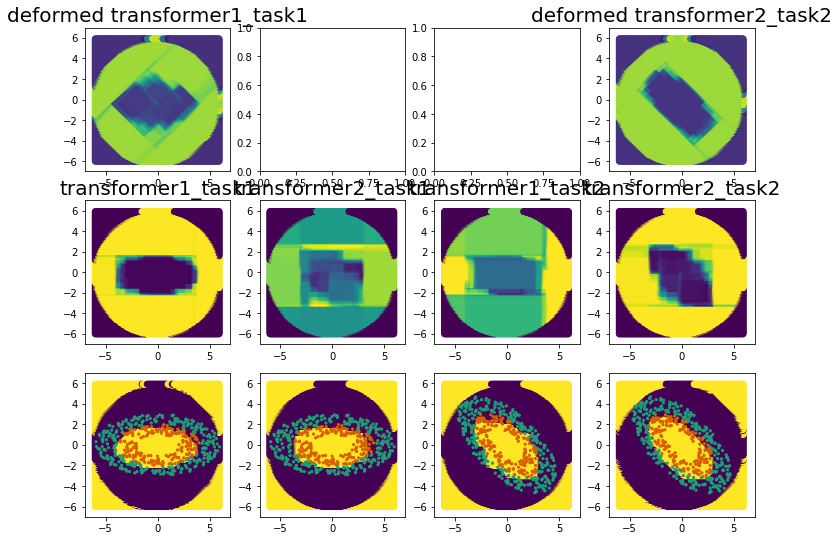

In [129]:
fig,axs = plt.subplots(3,4,figsize=(12,9))
colors = sns.color_palette('Dark2', n_colors=5)
data = [task1pred1_deformed, '', '', task2pred2_deformed]
titles = ['deformed transformer1_task1','','', 'deformed transformer2_task2']
xylim = [-7,7]
for i in range(4):
    ax = axs[0,i]
#     ax.axis('off')
    if data[i] != '':
        ax.scatter(xx,yy,c=data[i])
        ax.set_xlim(xylim); ax.set_ylim(xylim)
        ax.set_title(titles[i], fontsize=20)

data = [task1pred1_reshaped, task1pred2_reshaped, task2pred1_reshaped, task2pred2_reshaped]
titles = ['transformer1_task1', 'transformer2_task1', 'transformer1_task2', 'transformer2_task2']    
for i in range(4):
    ax = axs[1,i]
    ax.scatter(xx,yy,c=data[i])
    ax.set_xlim(xylim); ax.set_ylim(xylim)
#     ax.axis('off')
    ax.set_title(titles[i], fontsize=20)

data = [np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0),
        np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0),
        np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0),
        np.mean([task2pred2_reshaped, task2pred2_deformed], axis=0)]
pt = [test_x1, test_x1, test_x2_rot, test_x2_rot]
labels = [test_y1, test_y1, test_y2, test_y2]
for i in range(4):
    ax = axs[2,i]
    ax.scatter(xx,yy,c=np.where(data[i]>0.5, 0, 1))
    clr = [colors[i] for i in labels[i]]
    ax.scatter(pt[i][:, 0], pt[i][:, 1], c=clr, s=5)
    ax.set_xlim(xylim); ax.set_ylim(xylim)
#     ax.axis('off')
    

In [197]:
min(test_grid[:,1])

-6.0

In [248]:
def exp_reg_pos_asImg_OT(angle, n_trees=10, n_samples_source=200):
    angle = np.pi*angle/180
    train_x1, train_y1 = generate_rand_ellipse(n_samples_source)
    train_x2, train_y2 = generate_rand_ellipse(n_samples_source)
    train_x2_rot = rotate_data(train_x2, angle)

    test_x1, test_y1 = generate_rand_ellipse(n_samples_source)
    test_x2, test_y2 = generate_rand_ellipse(n_samples_source)
    test_x2_rot = rotate_data(test_x2, angle)
    xx, yy, inside, test_grid = to_grid_in_cir(test_x1, test_x2_rot)

    max_depth = ceil(log2(n_samples_source))
    l2f = init_forest(max_depth, 2) 
    uf = init_forest(max_depth, 2)
    l2f.add_task(train_x1, train_y1, num_transformers=n_trees)
    l2f.add_task(train_x2_rot, train_y2, num_transformers=n_trees)
    uf.add_task(train_x1, train_y1, num_transformers=2*n_trees)
    uf.add_task(train_x2_rot, train_y2, num_transformers=2*n_trees)

    # L2F
    l2f_task1 = generate_posteriors(test_grid, 0, l2f, [0,1])
    l2f_task2 = generate_posteriors(test_grid, 1, l2f, [0,1])
    task1pred1_reshaped = reshape_posteriors(inside, l2f_task1[0][:,0])
    task1pred2_reshaped = reshape_posteriors(inside, l2f_task1[1][:,0])
    task2pred1_reshaped = reshape_posteriors(inside, l2f_task2[0][:,0])
    task2pred2_reshaped = reshape_posteriors(inside, l2f_task2[1][:,0])

    uf_task1 = generate_posteriors(test_grid, 0, uf, [0])
    uf_task2 = generate_posteriors(test_grid, 1, uf, [1])
    task1pred1_reshaped_uf = reshape_posteriors(inside, uf_task1[0][:,0])
    task2pred1_reshaped_uf = reshape_posteriors(inside, uf_task2[0][:,0])

    errors = np.zeros(6,dtype=float)
    # L2F
    l2f_pred_task1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)[inside].ravel()
    l2f_task1 = vote_to_pred(l2f_pred_task1, test_x1, test_grid)
    errors[2] = 1-np.mean(np.argmax(l2f_task1, axis=1) == test_y1)
    l2f_pred_task2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)[inside].ravel()
    l2f_task2 = vote_to_pred(l2f_pred_task2, test_x2_rot, test_grid)
    errors[3] = 1-np.mean(np.argmax(l2f_task2, axis=1) == test_y2)
    # UF
    uf_pred_task1 = task1pred1_reshaped_uf[inside].ravel()
    uf_task1 = vote_to_pred(uf_pred_task1, test_x1, test_grid)
    errors[0] = 1-np.mean(np.argmax(uf_task1, axis=1) == test_y1)
    uf_pred_task2 = task2pred1_reshaped_uf[inside].ravel()
    uf_task2 = vote_to_pred(uf_pred_task2, test_x2_rot, test_grid)
    errors[1] = 1-np.mean(np.argmax(uf_task2, axis=1) == test_y2)

#     alg = OT_reg_pos_asPt(task1pred1_reshaped, task2pred2_reshaped)
#     for i in range(len(alg)):
#         deformed_task1 = alg[i][1]
#         deformed_task2 = alg[i][0]
#         pred_task1 = np.mean([task1pred1_reshaped, deformed_task1], axis=0)[inside].ravel()
#         OT_task1 = vote_to_pred(pred_task1, test_x1, test_grid)
#         errors[i*2+4] = 1 - np.mean(np.argmax(OT_task1, axis=1) == test_y1)
#         pred_task2 = np.mean([task2pred2_reshaped, deformed_task2], axis=0)[inside].ravel()
#         OT_task2 = vote_to_pred(pred_task2, test_x2_rot, test_grid)
#         errors[i*2+5] = 1 - np.mean(np.argmax(OT_task2, axis=1) == test_y2)

    # orthogonal procrustes
    task1pred1_reshaped_proc = task1pred1_reshaped.reshape((-1,1))
    task1pred1_reshaped_proc = np.hstack((task1pred1_reshaped_proc, 1-task1pred1_reshaped_proc))
    task2pred2_reshaped_proc = task2pred2_reshaped.reshape((-1,1))
    task2pred2_reshaped_proc = np.hstack((task2pred2_reshaped_proc, 1-task2pred2_reshaped_proc))
    aligner = OrthogonalProcrustes()
    deformed_task1 = aligner.fit_transform(task1pred1_reshaped_proc, task2pred2_reshaped_proc)
    aligner = OrthogonalProcrustes()
    deformed_task2 = aligner.fit_transform(task2pred2_reshaped_proc, task1pred1_reshaped_proc)

    deformed_task1 = deformed_task1[:,0].reshape(task1pred1_reshaped.shape)
    deformed_task2 = deformed_task2[:,0].reshape(task2pred2_reshaped.shape)
    pred_task1 = np.mean([task1pred1_reshaped, deformed_task1], axis=0)[inside].ravel()
    OT_task1 = vote_to_pred(pred_task1, test_x1, test_grid)
    errors[4] = 1 - np.mean(np.argmax(OT_task1, axis=1) == test_y1)
    pred_task2 = np.mean([task2pred2_reshaped, deformed_task2], axis=0)[inside].ravel()
    OT_task2 = vote_to_pred(pred_task2, test_x2_rot, test_grid)
    errors[5] = 1 - np.mean(np.argmax(OT_task2, axis=1) == test_y2)
    return errors

In [256]:
exp_reg_pos_asImg_OT(15)

array([0.045, 0.055, 0.06 , 0.06 , 0.055, 0.05 ])

### openml-cc18

In [40]:
# !pip install openml

In [38]:
import openml
import tqdm

In [215]:
task_id = 15
dataset = openml.datasets.get_dataset(openml.tasks.get_task(task_id).dataset_id)
X, y, is_categorical, _ = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
_, y = np.unique(y, return_inverse = True)
#X = np.nan_to_num(X[:, np.where(np.array(is_categorical) == False)[0]])
X = np.nan_to_num(X)

In [217]:
from scipy.ndimage.interpolation import rotate

In [227]:
X_rot = rotate(X, angle=45)
print(X_rot.shape)

(501, 501)


In [ ]:
# X_rot = np.swapaxes(rotate(X, 90, resize=True),0,1)

In [166]:
X_rot = np.rot90(X.swapaxes(0, 1))

In [176]:
def cross_val_openml_15(X, y, n_split=[300,600,699]):
    train_x1 = X[0:n_split[0], :]
    train_y1 = y[0:n_split[0]]
    train_x2 = X[n_split[0]:n_split[1], :]
    train_x2_rot = np.rot90(train_x2.swapaxes(0, 1))
    train_y2 = y[n_split[0]:n_split[1]]
    test_x = X[n_split[1]:n_split[2], :]
    test_y = y[n_split[1]:n_split[2]]
    
    return train_x1, train_y1, train_x2, train_x2_rot, train_y2, test_x, test_y


In [179]:
train_x1, train_y1, train_x2, train_x2_rot, train_y2, test_x, test_y =\
cross_val_openml_15(X, y)

In [36]:
np.array(openml.study.get_suite("OpenML-CC18").tasks)[17:]

array([    49,     53,    219,   2074,   2079,   3021,   3022,   3481,
         3549,   3560,   3573,   3902,   3903,   3904,   3913,   3917,
         3918,   7592,   9910,   9946,   9952,   9957,   9960,   9964,
         9971,   9976,   9977,   9978,   9981,   9985,  10093,  10101,
        14952,  14954,  14965,  14969,  14970, 125920, 125922, 146195,
       146800, 146817, 146819, 146820, 146821, 146822, 146824, 146825,
       167119, 167120, 167121, 167124, 167125, 167140, 167141])

In [ ]:
ids = np.array(openml.study.get_suite("OpenML-CC18").tasks)
for id in ids:
    dataset = openml.datasets.get_dataset(openml.tasks.get_task(id).dataset_id)
    X, y, is_categorical, _ = dataset.get_data(
        dataset_format="array", target=dataset.default_target_attribute
    )
    print(X.shape[1])

36
16
4
216
76
9
64
6
47
9
64
15
20
16
8
57
60
9
18
8
36
19
29
12
617
70
4
784
37
37
21
21
21
21
14
1776
30
5
41
24
256
10
500
118
72
856
51
4
4
30
37
16
32
561
12
40
42
77
27
18
5
6
16
240
784
6
21
